In [7]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import gc
import matplotlib.pyplot as plt

# 1) 회원정보 파일 경로 리스트
member_paths = [
    "open/train/1.회원정보/201807_train_회원정보.parquet",
    "open/train/1.회원정보/201808_train_회원정보.parquet",
    "open/train/1.회원정보/201809_train_회원정보.parquet",
    "open/train/1.회원정보/201810_train_회원정보.parquet",
    "open/train/1.회원정보/201811_train_회원정보.parquet",
    "open/train/1.회원정보/201812_train_회원정보.parquet",
]

# 2) 회원정보 통합 및 세그먼트 인코딩
df_members = pd.concat([pd.read_parquet(p)[['ID', 'Segment']] for p in member_paths])
le = LabelEncoder()
df_members['Segment_code'] = le.fit_transform(df_members['Segment'])

# 3) 분석에 사용할 파일과 컬럼
file_columns = {
    "open/train/3.승인매출정보/201812_train_승인매출정보.parquet": [
        'ID',  '정상청구원금_B0M', '이용금액_일시불_B0M', '이용금액_일시불_R6M', '이용금액_오프라인_B0M', '정상입금원금_B0M',
        '이용금액_오프라인_R3M','정상입금원금_B2M'

    ],
    "open/train/4.청구입금정보/201812_train_청구정보.parquet": [
        'ID', '청구금액_B0', '청구금액_R3M', '청구금액_R6M'
    ],
    "open/train/5.잔액정보/201812_train_잔액정보.parquet": [
        'ID', '평잔_일시불_6M', '월중평잔_일시불_B0M', '월중평잔_일시불', '평잔_일시불_3M', '잔액_할부_B0M'

    ]
}

# 4) 모든 데이터 병합
data_chunks = []
for path, cols in file_columns.items():
    df = pd.read_parquet(path, columns=cols)
    data_chunks.append(df)

data_merged = data_chunks[0]
for df in data_chunks[1:]:
    data_merged = pd.merge(data_merged, df, on='ID', how='inner')

# 5) 회원정보와 병합
full_df = pd.merge(data_merged, df_members[['ID', 'Segment_code']], on='ID', how='inner')

# 6) 결측치 제거
full_df.dropna(subset=['Segment_code'], inplace=True)

# 7) 피처와 타겟 분리
X = full_df.drop(columns=['ID', 'Segment_code'])
y = full_df['Segment_code']

# 8) 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9) 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 10) LightGBM 모델 학습
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train, feature_name=X.columns.tolist())

# 11) 예측 및 평가
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ 전체 테스트 정확도: {acc:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### 성능 향상을 위한 optuna 튜닝

In [15]:
!pip install optuna

In [23]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원래 학습 데이터에서 일부만 나눠 쓰자 (속도 ↑)
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 튜닝 목적 함수 정의
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 120),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_subtrain, y_subtrain)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    return acc

# 튜닝 실행 (빠르게 끝나도록 10회만)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 결과 출력
print("\n✅ Best Accuracy from tuning:", study.best_value)
print("✅ Best Parameters:", study.best_params_)

# 최적 파라미터로 전체 학습/평가
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
print(f"🎯 최적 모델 최종 테스트 정확도: {final_acc:.4f}")

[I 2025-07-04 00:35:23,167] A new study created in memory with name: no-name-2c7caec7-be8b-43af-a903-3116f578f43f


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:35:51,484] Trial 0 finished with value: 0.8321875 and parameters: {'num_leaves': 34, 'max_depth': 6, 'learning_rate': 0.12851586775505786, 'n_estimators': 96, 'subsample': 0.9825478636746436, 'colsample_bytree': 0.8199274748255085}. Best is trial 0 with value: 0.8321875.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:36:23,701] Trial 1 finished with value: 0.8592369791666666 and parameters: {'num_leaves': 45, 'max_depth': 10, 'learning_rate': 0.11499011717363618, 'n_estimators': 102, 'subsample': 0.834094764007913, 'colsample_bytree': 0.8826639085214192}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:36:46,478] Trial 2 finished with value: 0.854921875 and parameters: {'num_leaves': 39, 'max_depth': 4, 'learning_rate': 0.06293605628787322, 'n_estimators': 96, 'subsample': 0.9460862062272639, 'colsample_bytree': 0.8088800908494883}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:37:22,249] Trial 3 finished with value: 0.8576822916666667 and parameters: {'num_leaves': 40, 'max_depth': 6, 'learning_rate': 0.11566842329263329, 'n_estimators': 113, 'subsample': 0.8042661439163268, 'colsample_bytree': 0.9448020523338893}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:37:43,309] Trial 4 finished with value: 0.8540911458333333 and parameters: {'num_leaves': 44, 'max_depth': 3, 'learning_rate': 0.08331198864068613, 'n_estimators': 105, 'subsample': 0.956420610205918, 'colsample_bytree': 0.8969382693385082}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:38:01,749] Trial 5 finished with value: 0.8529114583333334 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.05551210708350858, 'n_estimators': 93, 'subsample': 0.8597645338167131, 'colsample_bytree': 0.8520863164279519}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-07-04 00:38:29,915] Trial 6 finished with value: 0.8546145833333333 and parameters: {'num_leaves': 57, 'max_depth': 10, 'learning_rate': 0.08732727820964668, 'n_estimators': 68, 'subsample': 0.9740292020580943, 'colsample_bytree': 0.9853501806491112}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:39:03,036] Trial 7 finished with value: 0.8020234375 and parameters: {'num_leaves': 38, 'max_depth': 7, 'learning_rate': 0.1450553772719762, 'n_estimators': 98, 'subsample': 0.8350224138313311, 'colsample_bytree': 0.950169881626437}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-07-04 00:39:33,192] Trial 8 finished with value: 0.8586458333333333 and parameters: {'num_leaves': 64, 'max_depth': 10, 'learning_rate': 0.058770173015941875, 'n_estimators': 67, 'subsample': 0.9171234142927978, 'colsample_bytree': 0.8955203910462917}. Best is trial 1 with value: 0.8592369791666666.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1536000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.659725
[LightGBM] [Info] Start training from score -2.934213
[LightGBM] [Info] Start training from score -1.928134
[LightGBM] [Info] Start training from score -0.221965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-04 00:39:46,313] Trial 9 finished with value: 0.85440625 and parameters: {'num_leaves': 52, 'max_depth': 4, 'learning_rate': 0.14654081800907498, 'n_estimators': 52, 'subsample': 0.8081320031952921, 'colsample_bytree': 0.8175671686242245}. Best is trial 1 with value: 0.8592369791666666.



✅ Best Accuracy from tuning: 0.8592369791666666


AttributeError: 'Study' object has no attribute 'best_params_'

In [25]:
# ⏪ Optuna에서 찾은 최적 파라미터로 전체 학습/평가
best_model = lgb.LGBMClassifier(**study.best_params)  # ← 언더바 없이!
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score
final_acc = accuracy_score(y_test, y_pred)
print(f"🎯 최적 모델 최종 테스트 정확도: {final_acc:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Start training from score -7.821445
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -2.935696
[LightGBM] [Info] Start training from score -1.927375
[LightGBM] [Info] Start training from score -0.222000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### segment 등급별 학습이 잘 되었는지 확인

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


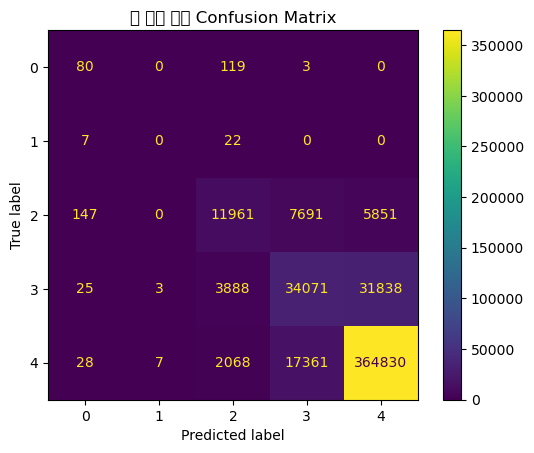

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("🎯 최적 모델 Confusion Matrix")
plt.show()

- LightGBM 기반 분류 모델을 통해 총 5개의 고객 세그먼트를 약 85.6%의 정확도로 예측하였다. 
- 가장 중요한 변수로는 '이용금액_일시불_R6M', '청구금액_B0', '잔액_할부_B0M' 등이 도출되었으며, 
- 특정 세그먼트 간의 오분류 비율이 높아 향후 데이터 보완 및 피처 엔지니어링 여지가 있다.

In [35]:
!pip install shap

   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   --------------------------------------- 545.3/545.3 kB 17.7 MB/s eta 0:00:00


### 학습 시 어느 데이터가 주요하게 사용되었는지 알 수 있다.

In [41]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 경로 예시
font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()


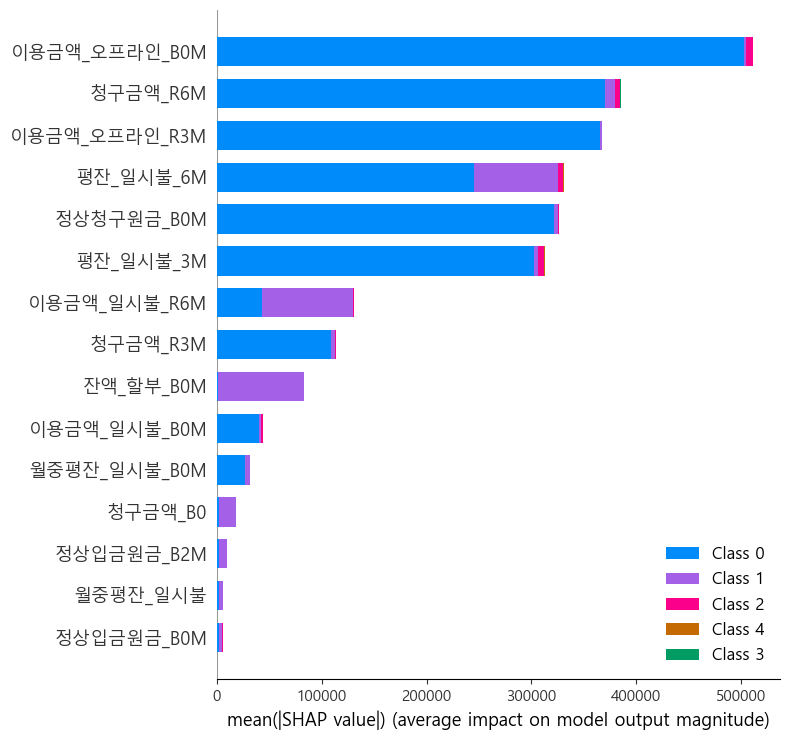

In [43]:
import shap
import pandas as pd

# 2000개 샘플 + 컬럼명 붙이기
X_sample = pd.DataFrame(X_test[:2000], columns=X.columns)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type='bar')

### 세그먼트 별 성능 상세 리포트

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.40      0.33       202
           1       0.00      0.00      0.00        29
           2       0.66      0.47      0.55     25650
           3       0.58      0.49      0.53     69825
           4       0.91      0.95      0.93    384294

    accuracy                           0.86    480000
   macro avg       0.48      0.46      0.47    480000
weighted avg       0.84      0.86      0.85    480000



### 모델의 안정성 평가

In [49]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# StratifiedKFold로 클래스 비율 유지하며 3겹 분할
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

acc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"Fold {fold+1} 시작")

    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**study.best_params)  # 튜닝된 파라미터 사용
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_pred_fold)
    acc_scores.append(acc)

    print(f"Fold {fold+1} 정확도: {acc:.4f}")

print(f"\n전체 평균 정확도: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")

Fold 1 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 15
[LightGBM] [Info] Start training from score -7.811623
[LightGBM] [Info] Start training from score -9.721166
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927459
[LightGBM] [Info] Start training from score -0.222075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

- 오차범위 ± 0.0046로 꽤나 안정성 있음

In [54]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# StratifiedKFold: 클래스 비율 유지하며 n_splits=3 (조정 가능)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"Fold {fold+1} 시작")

    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**study.best_params)  # 최적 하이퍼파라미터 적용
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')  # 다중 클래스용 가중평균

    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1} 정확도: {acc:.4f}, F1-score: {f1:.4f}")

print(f"\n전체 평균 정확도: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"전체 평균 F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Fold 1 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1600000, number of used features: 15
[LightGBM] [Info] Start training from score -7.811623
[LightGBM] [Info] Start training from score -9.721166
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927459
[LightGBM] [Info] Start training from score -0.222075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g